#  Task 3
## Statement

$$
\frac{k}{\mu B}\Delta_{x, y} p(t, x, y) = \frac{V_b \phi c }{\alpha}\frac{\partial}{\partial t}p(t, x)\\
\frac{\partial}{\partial x}\big(\frac{k_x A_x}{\mu B} \frac{\partial p}{\partial x}\big) 
+ q
=\frac{V_b \phi c }{\alpha}\frac{\partial p}{\partial t}
$$

$$ \frac{\partial }{\partial t} p= \frac{1}{\alpha} \Delta p + q\\
\frac{\partial}{\partial x}p(t, x, 0) = 0,\ p(t, L, y)=c_1,\ p(x, 0) = p_0\\
\frac{\partial}{\partial x}p(t, x, L) = 0,\ \frac{\partial}{\partial x}p(t, y, 0) = 0,
$$


<img src="figures/Task3.png">

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from math import ceil, floor

In [22]:
nx = 10
ny = 10

k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 1 # m
dy = 5 # m
c = 15.8e-10 # # Pa^-1
phi = 0.4
B = 1
mu = 2.9e-4  # m^2 / s
p_0 = 4e4 * 6894  # psi to Pa
p_b = 4.03e4 * 6894
d = 3  # m
dt = 1  # s
qw = -0.1 # m3/s

Теперь я поставлю задачу так - в центре есть скважина, в неё течёт $q=\texttt{const}$.

Нужно немного поправить матрицу для лапласиана

In [23]:
def lapl_martix(p_b, k, dx, dy, d, nx, ny, mu, B):
    lapl = np.zeros((nx*ny, nx*ny))
    # inner body
    for dia in range(nx*ny):
        # gonna have 4 neibours
        lapl[dia, dia] = -4 * k * d * dy / dx
        # two neibours on x - axis
        if (int((dia-1) / ny) == int(dia / ny)) & (dia-1 >= 0):
            lapl[dia, dia-1] = k * d * dy / dx
        if (int((dia+1) / ny) == int(dia / ny)) & (dia+1 < nx*ny):
            lapl[dia, dia+1] = k * d * dy / dx
        # two neybours on y axis
        if dia-ny >= 0:
            lapl[dia, dia-ny] = k * d * dy / dx
        if dia+ny < nx*ny:
            lapl[dia, dia+ny] = k * d * dy / dx
        
    for col in range(ny):
        # corners later
        if (col > 0) & (col < ny-1):
            # up bound
            lapl[col, col] = -3 * k * d * dy / dx
            # bot bound
            lapl[(nx-1) * ny + col, (nx-1) * ny + col] = -4 * k * d * dy / dx
        # bot bound
        # corners later
    for row in range(nx):
        if (row > 0) & (row < nx-1): 
            # left bound
            lapl[row * ny, row * ny] = -3 * k * d * dy / dx
            # right bound
            lapl[(row+1) * ny-1 , (row+1) * ny-1 ] = -3 * k * d * dy / dx
    lapl[0, 0] = -2 * k * d * dy / dx
    lapl[ny-1, ny-1] = -2 * k * d * dy / dx
    lapl[nx*ny-1, nx*ny-1] = -3 * k * d * dy / dx
    lapl[nx*ny-1 - (ny-1), nx*ny-1 - (ny-1)] = -3 * k * d * dy / dx
    lapl *= 1 / (mu * B)
    return lapl

In [24]:
lapl = lapl_martix(p_b, k, dx, dy, d, nx, ny, mu, B)

А $\vec{\tilde{q}}$ становится намного сложнее

In [25]:
wells_q = {(4, 4): -1e-3}

In [26]:
def get_q_bound(p_b, k, dx, dy, d, nx, ny, mu, B, wells_q):
    q_tilde = np.zeros((nx, ny))
    for col in range(ny):
        q_tilde[nx-1, col] = k * d * dy / (dx * mu * B) * p_b
        
    for well in wells_q:
        q_tilde[well] += wells_q[well]
        
    q_tilde = q_tilde.reshape((-1, 1))
    return q_tilde

In [27]:
q_tilde = get_q_bound(p_b, k, dx, dy, d, nx, ny, mu, B, wells_q)

In [28]:
dt_coeff = dx * dy * d * phi * c / dt

К сожалению, анаилическое решение  этой задаче представить нет возможности

In [29]:
n_iter = int(1.2e3)
p_ex = np.ones((nx*ny, 1)) * p_0
p_im = np.ones((nx*ny, 1)) * p_0
t = 0
xs = list(np.linspace(0, nx-1, nx) * dx * 1.01)
plot_freq = int(1e1)

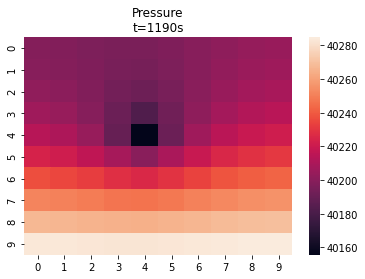

In [30]:
for i in range(1, n_iter):
    # upd pressure
    p_ex += 1 / dt_coeff * (lapl.dot(p_ex) + q_tilde)
    t += dt
    if i % plot_freq == 0:
    # append some history
    # let's draw
        display.clear_output(wait=True)
        sns.heatmap(p_ex.reshape((nx, ny)) / 6894., cbar=True)
        plt.title(f'Pressure\nt={t}s')
        plt.show()